In [ ]:
## Watch this to understand how to use the ecosystem daata as quickly as possible
# https: // www.dropbox.com/sh/iysbzchdix2dc55/AAD9t53ntFNtTbyAYyIIdtjRa?dl = 0
# https://www.kaggle.com/c/melbourne-university-seizure-prediction
# Dr Levin Kuhlmann (levin.kuhlmann@monash.edu),

## Imports

In [60]:
import pandas as pd
import scipy.io as sio
import numpy as np
import os
import glob


In [83]:
data_root = '/Users/Shared/Box/Neurovista'
study = 'Pat1Test'
#data_file = 'Pat1Train_1_1.mat'
header = ['ch0',	'ch1',	'ch2',	'ch3',	'ch4',	'ch5',	'ch6',	'ch7',	'ch8',	'ch9',	'ch10',	'ch11',	'ch12',	'ch13',	'ch14',	'ch15']
studyHeader = ['study', 'segment', 'type']
studyHeader_train = ['study','block_id', 'segment', 'type']
analysis_root = '/Users/Shared/Box/Neurovista/analysis'
data_label_root = '/Users/Shared/Box/Neurovista/data_labels'

## Load Train File

In [5]:
train_labels = pd.read_csv(data_label_root + '/contest_train_data_labels.csv')
train_labels_1 = train_labels[train_labels['class']==1]
#train_labels_1 = train_labels

# new data frame with split value columns
new = train_labels_1["image"].str.split("_", n = 2, expand = True)
  
# making separate first name column from new data frame
train_labels_1["patient"]= new[0]
  
# making separate last name column from new data frame
train_labels_1["segment"]= new[1]

train_labels_1["segment"] = train_labels_1["segment"].astype(int)

train_labels_1["block_id"]= np.ceil(np.array(train_labels_1['segment']/6))
train_labels_1["block_id"] = train_labels_1["block_id"].astype(int)

train_labels_1 = train_labels_1[train_labels_1['patient']==study]
train_labels_1["class"] = train_labels_1["class"].astype(int)

train_labels_1 = train_labels_1[train_labels_1['segment']<= 150]

<ipython-input-5-7fe8bcd0f9c0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_labels_1["patient"]= new[0]
<ipython-input-5-7fe8bcd0f9c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_labels_1["segment"]= new[1]
<ipython-input-5-7fe8bcd0f9c0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

## Load Test files

In [100]:
# Load contest test data labels that are public (30% of dataset)
test_labels = pd.read_csv(data_label_root +'/contest_test_data_labels_public.csv')
test_labels_public = test_labels[test_labels['usage']=='Public']
# test_labels_publi÷c.drop([2], axis=1)
# Split image column into two columns: patient i and segment j
test_labels_df = test_labels_public["image"].str.split("_", n = 2, expand = True).drop([2], axis=1)
test_labels_df.columns = ['patient', 'segment']
test_labels_df["class"] = test_labels_public["class"].astype(int)
test_labels_df["segment"] = test_labels_df["segment"].astype(int)
test_labels_df[test_labels_df['patient'] == study]

# test_labels_public

,patient,segment,class
0,Pat1Test,1,0
2,Pat1Test,3,1
5,Pat1Test,6,0
8,Pat1Test,9,0
10,Pat1Test,11,0
...,...,...,...
203,Pat1Test,204,1
206,Pat1Test,207,0
207,Pat1Test,208,1
210,Pat1Test,211,0


In [ ]:
Pat1Test_df = pd.DataFrame()
matFiles = data_root+study+'/'+test_labels_public["image"]+'.mat'
for matFilePath in matFiles:
  print(matFilePath)
  loadedMatFile = sio.loadmat(matFilePath)['data']

  file_name = matFilePath.split('/')[-1].split('.')[0]
  file_name_row = test_labels_public[test_labels_public['image'] == file_name]
  newColumns = [file_name_row[['patient','segment','class']].values] * np.shape(loadedMatFile)[0]
  newColumns = np.squeeze(newColumns,axis=1)

  study_df = pd.DataFrame(newColumns, columns=studyHeader)
  mat_df = pd.DataFrame(loadedMatFile, columns=header)
  result = pd.concat([study_df, mat_df], axis=1)
  Pat1Test_df = pd.concat([Pat1Test_df,result])

Pat1Test_df.study = Pat1Test_df.study.astype(str)
Pat1Test_df.segment = Pat1Test_df.segment.astype(int)
Pat1Test_df['type'] = Pat1Test_df['type'].astype(int

## Convert .mat to csv

## Load data using Dask

In [79]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

/Users/mosadoluwaobatusin/opt/anaconda3/envs/nma-dl/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51438 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://192.168.1.5:51438/status,
Status: running,Using processes: False
Dashboard: http://192.168.1.5:51438/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Comm: inproc://192.168.1.5/49360/16,Workers: 1
Dashboard: http://192.168.1.5:51438/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://192.168.1.5/49360/18,Total threads: 4
Dashboard: http://192.168.1.5:51439/status,Memory: 1.86 GiB
Nanny: None,


In [7]:
from time import sleep
from dask import delayed

In [8]:
@delayed
def inc(x):
   sleep(1)
   return x + 1

@delayed
def add(x,y):
   sleep(1)
   return x  + y

In [9]:
%%time
x = inc(1)
y = inc(2)

z = add(x,y)

CPU times: user 793 µs, sys: 528 µs, total: 1.32 ms
Wall time: 992 µs


In [10]:
%%time

x = delayed(inc)(1)
y = delayed(inc)(2)

z = delayed(add)(x,y)

CPU times: user 925 µs, sys: 903 µs, total: 1.83 ms
Wall time: 1.21 ms


In [11]:
z

Delayed('add-4bba5c25-2e70-42c8-b60b-e42c2b5279e8')

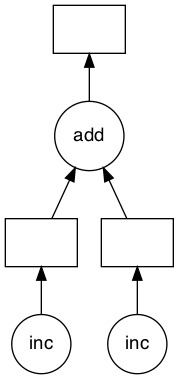

In [13]:
z.visualize()

In [74]:
# Parallelizing a for loop
data = [1,2,3,4,5,6,7,8]

In [75]:
%%time
results = []
for x in data:
   y = inc(x)
   results.append(y)
total = sum(results)

CPU times: user 1.62 ms, sys: 1.12 ms, total: 2.74 ms
Wall time: 1.94 ms


In [76]:
results

[Delayed('inc-096b4029-daa7-416d-9144-8b5b298762e8'),
 Delayed('inc-36148c04-1d36-42de-8cf5-26d70ca445a7'),
 Delayed('inc-c6edde12-6ec6-4bc3-a0fc-36f542e13812'),
 Delayed('inc-2aafd2f5-3fb3-4b28-821c-bae4c0c2d723'),
 Delayed('inc-2bfe111b-3dd1-43f0-ba01-d68dddd148e9'),
 Delayed('inc-9e2cc40e-479a-4994-9591-a22418f0e9b7'),
 Delayed('inc-954ee20b-f4ce-4ea9-ba20-f6adade61680'),
 Delayed('inc-8b8bca19-3ad0-438a-a546-ba0b51675334')]

In [17]:
%%time
results = []
for x in data:
   y = delayed(inc)(x)
   results.append(y)
total = delayed(sum)(results)

CPU times: user 904 µs, sys: 550 µs, total: 1.45 ms
Wall time: 1.17 ms


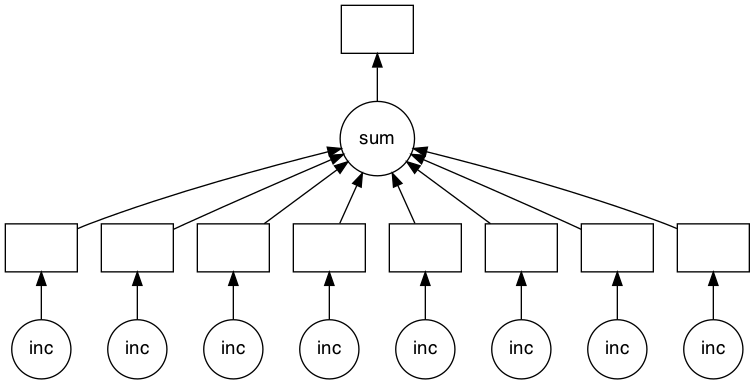

In [57]:
total.visualize()

In [78]:
Pat1Test_df = pd.DataFrame()
results = []
@delayed
def loadMatFile(matFilePath):
   loadedMatFile = sio.loadmat(matFilePath)['data']
   file_name = matFilePath.split('/')[-1].split('.')[0]
   file_name_row = test_labels_public[test_labels_public['image'] == file_name]
   newColumns = [file_name_row[['patient','segment','class']].values] * np.shape(loadedMatFile)[0]
   newColumns = np.squeeze(newColumns,axis=1)

   study_df = pd.DataFrame(newColumns, columns=studyHeader)
   mat_df = pd.DataFrame(loadedMatFile, columns=header)
   return pd.concat([study_df, mat_df], axis=1)

   return results

@delayed
def concatDataframe(Pat1Test_df,result):
   return pd.concat([Pat1Test_df,result])

In [67]:
dataFile = os.listdir('/Users/Shared/Box/Neurovista/data/Pat1Test')

In [69]:
for data in dataFile:
   y = delayed(loadMatFile)('/Users/Shared/Box/Neurovista/data/Pat1Test'+'data')
   results = delayed(concatDataframe)(Pat1Test_df,y)

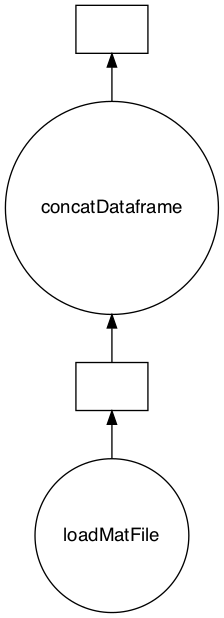

In [71]:
results.visualize()

## Dask Dataframe

In [52]:
# download the NYC flights dataset to our workspace
import urllib

print(" - Downloading NYC flights dataset...", end='', flush=True)
url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
filename, headers = urllib.request.urlretrieve(url, 'nycflights.tar.gz')
print("Done!", flush=True)

 - Downloading NYC flights dataset...Done!


In [53]:
import tarfile

#extract the .csv files from the tar file
with tarfile.open(filename, mode='r:gz') as flights:
   flights.extractall('data/')

In [48]:
import os
import dask.dataframe as dd


df = dd.read_csv(os.path.join('data', 'nycflights', '*csv'), 
                  parse_dates={'Date':[0,1,2]})

df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [54]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*csv'), 
                  parse_dates={'Date':[0,1,2]},
                  dtype={'TailNum': str,
                  'CRSElapsedTIime': float,
                  'Cancelled': bool})

df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,int64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [55]:
df.DepDelay.max().compute()

distributed.worker - WARNING - Compute Failed
Function:  _reduction_chunk
args:      ((<Serialize: subgraph_callable-c001d445-c87a-478d-8ed0-7d4f50960bbb>, <Serialize: [(<function read_block_from_file at 0x7ff2e35ef4c0>, <OpenFile '/Users/mosadoluwaobatusin/Documents/Projects/Neuromatch Academy 2021/NMA_DL/NeuromatchAcademy_DeepLearning_Coursework/data/nycflights/1990.csv'>, 0, 64000000, b'\n'), None, True]>))
kwargs:    {'aca_chunk': <methodcaller: max>, 'skipna': True, 'axis': 0}
Exception: AttributeError("'tuple' object has no attribute 'max'")

distributed.worker - WARNING - Compute Failed
Function:  _reduction_chunk
args:      ((<Serialize: subgraph_callable-c001d445-c87a-478d-8ed0-7d4f50960bbb>, <Serialize: [(<function read_block_from_file at 0x7ff2e35ef4c0>, <OpenFile '/Users/mosadoluwaobatusin/Documents/Projects/Neuromatch Academy 2021/NMA_DL/NeuromatchAcademy_DeepLearning_Coursework/data/nycflights/1991.csv'>, 0, 64000000, b'\n'), None, True]>))
kwargs:    {'aca_chunk': <metho

AttributeError: 'tuple' object has no attribute 'max'

In [34]:
df = dd.read_hdf(os.path.join('/Users/Shared/Box/Neurovista/Pat1Test','*.hdf5'),key='data')

In [39]:
%%time
df.ch0.max().compute()

distributed.worker - WARNING - Compute Failed
Function:  subgraph_callable-14e6c8e4-cc91-403b-a0b1-6ea5ed01
args:      (<Serialize: ('/Users/Shared/Box/Neurovista/Pat1Test/Pat1Test_1_0.hdf5', '/data', {'start': 0, 'stop': 1000000})>)
kwargs:    {}
Exception: TypeError('cannot unpack non-iterable Serialize object')

distributed.worker - WARNING - Compute Failed
Function:  subgraph_callable-14e6c8e4-cc91-403b-a0b1-6ea5ed01
args:      (<Serialize: ('/Users/Shared/Box/Neurovista/Pat1Test/Pat1Test_2_0.hdf5', '/data', {'start': 0, 'stop': 1000000})>)
kwargs:    {}
Exception: TypeError('cannot unpack non-iterable Serialize object')

distributed.worker - WARNING - Compute Failed
Function:  subgraph_callable-14e6c8e4-cc91-403b-a0b1-6ea5ed01
args:      (<Serialize: ('/Users/Shared/Box/Neurovista/Pat1Test/Pat1Test_3_0.hdf5', '/data', {'start': 0, 'stop': 1000000})>)
kwargs:    {}
Exception: TypeError('cannot unpack non-iterable Serialize object')

distributed.worker - WARNING - Compute Failed
Fun

TypeError: cannot unpack non-iterable Serialize object